In [5]:
import numpy as np
import pandas as pd
import warnings
import os
from tqdm import tqdm
from sklearn import preprocessing, metrics
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from collections import Counter
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
warnings.filterwarnings('ignore')

In [6]:
train_path = '../data/eleme_round1_train/'
test_path = '../data/eleme_round1_testB/'

In [7]:
# 读取数据并加入date列
def read_datafile(rootpath, section):
    file_path = rootpath + section + '/'
    data_list = []

    for f in os.listdir(file_path):
        date = f.split('.')[0].split('_')[1]
        if section == 'action':
            df = pd.read_csv(file_path+f,converters={'tracking_id':str})
        elif section == 'order':
            df = pd.read_csv(file_path+f,converters={'tracking_id':str})
        elif section == 'courier':
            df = pd.read_csv(file_path+f)
        elif section == 'distance':
            df = pd.read_csv(file_path+f,converters={'tracking_id':str, 'target_tracking_id':str})
        df['date'] = date
        data_list.append(df)
    return pd.concat(data_list)

def majorid(df):
    df['majorid'] = df['date'].map(str) + df['courier_id'].map(str) + '_' + df['wave_index'].map(str)
    return df

def dropdate(df):
    df.drop(['date', 'courier_id', 'wave_index'], axis=1, inplace=True)
    return df

# 一、特征工程

In [8]:
courier_train = read_datafile(train_path, 'courier')
courier_test = read_datafile(test_path, 'courier')

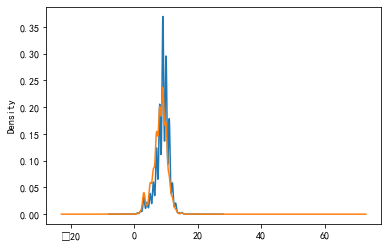

In [9]:
courier_train["max_load"].plot(kind="kde")
courier_test["max_load"].plot(kind="kde")

In [10]:
courier_test.head()

,courier_id,level,speed,max_load,date
0,10513697,3,5.200227,9,20200301
1,10656566,3,5.778374,10,20200301
2,10711180,3,5.942210,8,20200301
3,107672506,2,5.676442,6,20200301
4,10788423,3,6.090295,9,20200301


# order

In [11]:
dict_weather={"正常天气":1,"轻微恶劣天气":2,"恶劣天气":3,"极恶劣天气":4,"罕见恶劣天气":5}

In [12]:
order_raw_train = read_datafile(train_path, 'order')
order_raw_test = read_datafile(test_path, 'order')

In [13]:
order_train = majorid(order_raw_train)
order_test = majorid(order_raw_test)

In [14]:
def tanlism_order(df):
    df['delivery_tan'] = (df['deliver_lat']-df['pick_lat']) / (df['deliver_lng']-df['pick_lng'])
    df['delivery_tan'] = np.arctan(df['delivery_tan'])
    df['delivery_tan'] = -np.degrees(df['delivery_tan'])
    df['delivery_MHD'] = abs(df['deliver_lat']-df['pick_lat']) + abs(df['deliver_lng']-df['pick_lng'])*100000.0
    df["delta_time_ac"]=df["assigned_time"]-df["confirm_time"]
    df["delta_time_pc"]=df["promise_deliver_time"]-df["confirm_time"]
    df["delta_time_pa"]=df["promise_deliver_time"]-df["assigned_time"]
    df["weather_grade"]=df["weather_grade"].map(dict_weather)
    df.drop(['deliver_lat', 'pick_lat', 'deliver_lng', 'pick_lng',"create_time","aoi_id","shop_id"], axis=1, inplace=True)
    return df

In [15]:
order_train = tanlism_order(order_train)
order_test = tanlism_order(order_test)

In [16]:
order_test.head(5)

,courier_id,wave_index,tracking_id,weather_grade,confirm_time,assigned_time,promise_deliver_time,estimate_pick_time,date,majorid,delivery_tan,delivery_MHD,delta_time_ac,delta_time_pc,delta_time_pa
0,100002543,3,2100076043279042258,1,1583036108,1583036150,1583038927,1583037308,20200301,20200301100002543_3,-38.920168,687.205549,42,2819,2777
1,100002543,3,2100076045156320581,1,1583036575,1583036629,1583039154,1583037835,20200301,20200301100002543_3,79.090078,319.016550,54,2579,2525
2,100002543,3,2100076044413207877,1,1583036762,1583036809,1583039641,1583038022,20200301,20200301100002543_3,81.728451,239.016440,47,2879,2832
3,100002543,3,2100076044139038021,1,1583037266,1583037289,1583040204,1583038706,20200301,20200301100002543_3,74.663627,458.016700,23,2938,2915
4,100002543,3,2100076045016368756,1,1583037530,1583037829,1583040530,1583038430,20200301,20200301100002543_3,-88.456967,78.929290,299,3000,2701


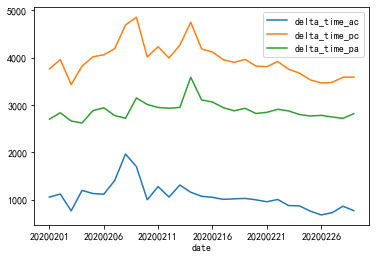

In [17]:
order_train.groupby("date")[["delta_time_ac","delta_time_pc","delta_time_pa"]].mean().plot()

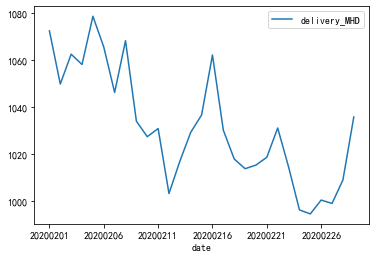

In [18]:
order_train.groupby("date")[["delivery_MHD"]].mean().plot()

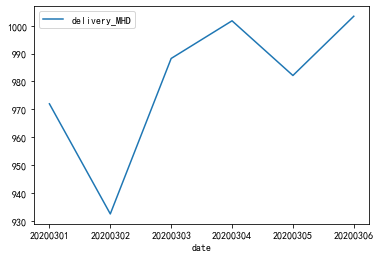

In [19]:
order_test.groupby("date")[["delivery_MHD"]].mean().plot()

# distance数据

In [20]:
distance_train = read_datafile(train_path, 'distance')
distance_test = read_datafile(test_path, 'distance')

In [21]:
distance_train = majorid(distance_train)
distance_test = majorid(distance_test)

In [22]:
def tanlism_distance(df):
    df['target_tan'] = (df['source_lat']-df['target_lat']) / (df['source_lng']-df['target_lng']) 
    df['target_tan'] = np.arctan(df['target_tan'])
    df['target_tan'] = -np.degrees(df['target_tan'])
    df['target_MHD'] = abs(df['source_lat']-df['target_lat']) + abs(df['source_lng']-df['target_lng'])*100000.0
    df.drop(['source_lat', 'target_lat', 'source_lng', 'target_lng'], axis=1, inplace=True)
    return df

In [23]:
distance_train.head(5)

,courier_id,wave_index,tracking_id,source_type,source_lng,source_lat,target_tracking_id,target_type,target_lng,target_lat,grid_distance,date,majorid
0,100002543,0,2100074536706869066,ASSIGN,121.641337,39.141340,2100074542836254538,ASSIGN,121.635755,39.141497,542.0,20200201,20200201100002543_0
1,100002543,0,2100074542836254538,PICKUP,121.647214,39.135549,2100074542836254538,ASSIGN,121.635755,39.141497,2042.0,20200201,20200201100002543_0
2,100002543,0,2100074542836254538,DELIVERY,121.647324,39.126481,2100074542836254538,ASSIGN,121.635755,39.141497,3343.0,20200201,20200201100002543_0
3,100002543,0,2100074536706869066,PICKUP,121.647214,39.135549,2100074542836254538,ASSIGN,121.635755,39.141497,2042.0,20200201,20200201100002543_0
4,100002543,0,2100074536706869066,DELIVERY,121.655694,39.123121,2100074542836254538,ASSIGN,121.635755,39.141497,3945.0,20200201,20200201100002543_0


In [24]:
distance_train = tanlism_distance(distance_train)
distance_test = tanlism_distance(distance_test)

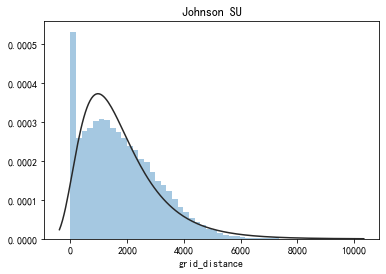

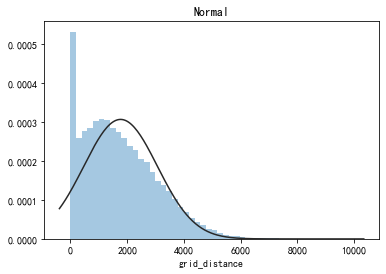

In [25]:
import scipy.stats as st
y = distance_train["grid_distance"].head(100000)
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

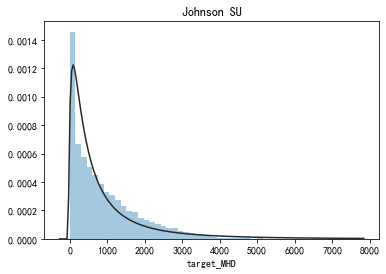

In [26]:
import scipy.stats as st
y = distance_train["target_MHD"].head(100000)
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

# action的操作

In [27]:
action_train = read_datafile(train_path, 'action')
action_test = read_datafile(test_path, 'action')

In [28]:
action_train = majorid(action_train)
action_test = majorid(action_test)

In [29]:
def action_train_group(df):
    groups = df.groupby(['majorid'])
    df_future = []
    df_last = []
    cand_dict={}  ## name:pick:set()  
    for name, group in tqdm(groups):
        future_data = group.tail(int(group.shape[0] * 0.55))   ## 做预测的
        last_data = group.drop(future_data.index)     ## 做特征的
        future_data= future_data.head(8)

        # if last_data.shape[0] < 3:
        #     continue  # 丢弃少于三个时序的训练样本
        n= last_data.shape[0]
        
        if n==1:
            temp1=None
            temp2=None
        elif n==2:
            temp1=last_data.tail(3)["action_type"].values[0] # 之前一条的操作
            temp2=None
        else:
            temp2=last_data.tail(3)["action_type"].values[0] # 之前二条的操作
            temp1=last_data.tail(3)["action_type"].values[1] # 之前一条的操作

        cand_dict[name]=set(last_data["tracking_id"])  ## pick过的dict,  #格式cand_dict:{'20200201100069773_3': set(t1,t2,...)}
        last_data["load"]=list(Counter(last_data["tracking_id"]).values()).count(1)  ## 骑手当前负载量
        future_data["load"]=list(Counter(last_data["tracking_id"]).values()).count(1)  ## 骑手当前负载量

        # last操作

        last_data = last_data.tail(1)
        last_data.reset_index(drop=True, inplace=True)
        last_data["old_action_1"]=temp1
        last_data["old_action_2"]=temp2  

        # 对future处理（预测label）

        ## 筛选数据集
        future_data=future_data[~(~future_data['tracking_id'].isin(cand_dict[name]) & (future_data['action_type'].isin(["DELIVERY"])))]
        n2=future_data.shape[0]
        future_data["old_action_1"]=temp1
        future_data["old_action_2"]=temp2 

        future_data['label'] = 0
        future_data.reset_index(drop=True, inplace=True)
        future_data.loc[0,'label'] = 1# 标记正负样本

        df_future.append(future_data)
        df_last.append(last_data)
    print("开始concat last")
    return_last = pd.concat(df_last)
    print("开始concat future")
    return_future = pd.concat(df_future)
    return_last.rename({'expect_time' : 'last_time'}, axis=1, inplace=True)# 把expecttime列重命名
    # return_future = shuffle(return_future)# 随机打乱顺序
    return return_last, return_future

def action_test_group(df):
    groups = df.groupby(['majorid'])
    df_future = []
    df_last = []
    cand_dict={}  ## name:pick:set() 

    for name, group in tqdm(groups):
        future_data = group[group['expect_time']==0]
        last_data = group.drop(future_data.index)

        n= last_data.shape[0]
        if n==1:
            temp1=None
            temp2=None
        elif n==2:
            temp1=last_data.tail(3)["action_type"].values[0] # 之前一条的操作
            temp2=None
        else:
            temp2=last_data.tail(3)["action_type"].values[0] # 之前二条的操作
            temp1=last_data.tail(3)["action_type"].values[1] # 之前一条的操作
 
        cand_dict[name]=set(last_data["tracking_id"])  ## pick过的dict,  #格式cand_dict:{'20200201100069773_3': set(t1,t2,...)}
        last_data["load"]=list(Counter(last_data["tracking_id"]).values()).count(1)  ## 骑手当前负载量
        future_data["load"]=list(Counter(last_data["tracking_id"]).values()).count(1)  ## 骑手当前负载量
    
        # last操作
        last_data = last_data.tail(1)
        last_data.reset_index(drop=True, inplace=True)
        last_data["old_action_1"]=temp1
        last_data["old_action_2"]=temp2
        # future操作
        ## 筛选数据集
        future_data=future_data[~(~future_data['tracking_id'].isin(cand_dict[name]) & (future_data['action_type'].isin(["DELIVERY"])))]
        future_data["old_action_1"]=temp1
        future_data["old_action_2"]=temp2
        future_data['label'] = None

        df_future.append(future_data)
        df_last.append(last_data)
    print("开始concat last")
    return_last = pd.concat(df_last)
    print("开始concat future")
    return_future = pd.concat(df_future)
    return_last.rename({'expect_time' : 'last_time'}, axis=1, inplace=True)
    return return_last, return_future

In [26]:
action_train_thelast, action_train_future = action_train_group(action_train)

100%|██████████| 82533/82533 [08:46<00:00, 156.80it/s]
开始concat last
开始concat future


In [27]:
action_train_thelast.head() 

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,last_time,date,majorid,load,old_action_1,old_action_2
0,100002543,0,2100074536706869066,121.635755,39.141497,PICKUP,1580519758,20200201,20200201100002543_0,2,PICKUP,None
0,100002543,1,2100074546118723550,121.631040,39.137702,PICKUP,1580524468,20200201,20200201100002543_1,2,PICKUP,None
0,100002543,2,2100074572925863604,121.642295,39.135482,PICKUP,1580550426,20200201,20200201100002543_2,2,PICKUP,None
0,100002652,0,2100074545867785801,121.566098,39.144913,PICKUP,1580524091,20200201,20200201100002652_0,2,PICKUP,None
0,100002652,1,2100074548127335429,121.570003,39.149020,DELIVERY,1580527901,20200201,20200201100002652_1,1,PICKUP,PICKUP


In [28]:
action_train_future.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,load,old_action_1,old_action_2,label
0,100002543,0,2100074542836254538,121.635755,39.141497,DELIVERY,1580520355,20200201,20200201100002543_0,2,PICKUP,None,1
1,100002543,0,2100074536706869066,121.635755,39.141497,DELIVERY,1580520770,20200201,20200201100002543_0,2,PICKUP,None,0
0,100002543,1,2100074546090674142,121.631040,39.137702,DELIVERY,1580525047,20200201,20200201100002543_1,2,PICKUP,None,1
1,100002543,1,2100074546118723550,121.631040,39.137702,DELIVERY,1580525705,20200201,20200201100002543_1,2,PICKUP,None,0
0,100002543,2,2100074572925863604,121.642295,39.135482,DELIVERY,1580550955,20200201,20200201100002543_2,2,PICKUP,None,1


In [29]:
action_test_thelast, action_test_future = action_test_group(action_test)

100%|██████████| 4193/4193 [00:25<00:00, 162.10it/s]
开始concat last
开始concat future


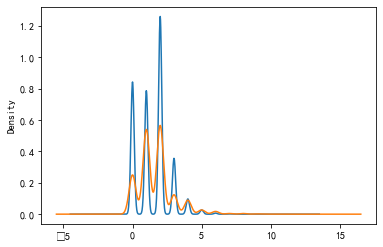

In [30]:
action_train_thelast["load"].plot(kind="kde")
action_test_thelast["load"].plot(kind="kde")  ## 当前负载单

In [31]:
action_test_future.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,load,old_action_1,old_action_2,label
403,100002543,3,2100076045156320581,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,3,PICKUP,PICKUP,None
404,100002543,3,2100076044413207877,121.634234,39.143629,PICKUP,0,20200301,20200301100002543_3,3,PICKUP,PICKUP,None
405,100002543,3,2100076045016368756,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,3,PICKUP,PICKUP,None
406,100002543,3,2100076044139038021,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,3,PICKUP,PICKUP,None
3540,100006950,3,2100076085507393263,121.412991,39.032091,DELIVERY,0,20200301,20200301100006950_3,2,PICKUP,DELIVERY,None


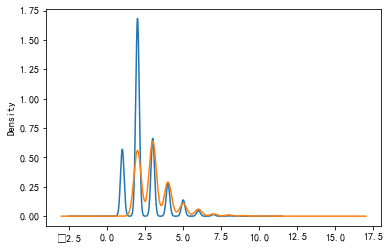

In [32]:
action_train_future.groupby("majorid")["courier_id"].count().plot(kind="kde")  # tesint集中每个group可选择的数量的分布
action_test_future.groupby("majorid")["courier_id"].count().plot(kind="kde")  # test集中每个group可选择的数量的分布

In [33]:
action_train_future["label"][action_train_future["label"]==0].count(),action_train_future["label"][action_train_future["label"]==1].count()

(115523, 82533)

In [37]:
action_train_thelast.to_pickle('../user_data/tmp_data/action_train_thelast.pkl')
action_train_future.to_pickle('../user_data/tmp_data/action_train_future.pkl')

action_test_thelast.to_pickle('../user_data/tmp_data/action_test_thelast.pkl')
action_test_future.to_pickle('../user_data/tmp_data/action_test_future.pkl')

# Merge

In [30]:
import numpy as np
import pandas as pd
import warnings
import os
from tqdm import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from collections import Counter
import time 
import datetime
import scipy
import matplotlib 
from sklearn.utils import shuffle
import sklearn
from sklearn import preprocessing, metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle# 随机排列

from sklearn import preprocessing
import gc
import xgboost as xgb 
import joblib

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
warnings.filterwarnings('ignore')

In [31]:
action_train_thelast=pd.read_pickle("../user_data/tmp_data/action_train_thelast.pkl")
action_train_future=pd.read_pickle("../user_data/tmp_data/action_train_future.pkl")
action_test_thelast=pd.read_pickle("../user_data/tmp_data/action_test_thelast.pkl")
action_test_future=pd.read_pickle("../user_data/tmp_data/action_test_future.pkl")

In [32]:
action_train_thelast.drop(["date","courier_id","wave_index","courier_wave_start_lng","courier_wave_start_lat"], axis=1, inplace=True)
action_test_thelast.drop(["date","courier_id","wave_index","courier_wave_start_lng","courier_wave_start_lat"], axis=1, inplace=True)
action_train_future.drop(["load","old_action_1","old_action_2"], axis=1, inplace=True)
action_test_future.drop(["load","old_action_1","old_action_2"], axis=1, inplace=True)

rename_rule_d = {'source_type' : 'last_action_type',"target_type":"action_type","tracking_id":"last_tracking_id","target_tracking_id":"tracking_id"}
distance_train.rename(rename_rule_d, axis=1, inplace=True)
distance_test.rename(rename_rule_d, axis=1, inplace=True)

rename_rule_alast = {'action_type' : 'last_action_type',"tracking_id":"last_tracking_id"}
action_train_thelast.rename(rename_rule_alast, axis=1, inplace=True)
action_test_thelast.rename(rename_rule_alast, axis=1, inplace=True)

order_train.drop(["date","courier_id","wave_index","confirm_time","delta_time_pa","delta_time_ac"], axis=1, inplace=True)
order_test.drop(["date","courier_id","wave_index","confirm_time","delta_time_pa","delta_time_ac"], axis=1, inplace=True)

In [33]:
action_train_thelast.head()

,last_tracking_id,last_action_type,last_time,majorid,load,old_action_1,old_action_2
0,2100074536706869066,PICKUP,1580519758,20200201100002543_0,2,PICKUP,None
0,2100074546118723550,PICKUP,1580524468,20200201100002543_1,2,PICKUP,None
0,2100074572925863604,PICKUP,1580550426,20200201100002543_2,2,PICKUP,None
0,2100074545867785801,PICKUP,1580524091,20200201100002652_0,2,PICKUP,None
0,2100074548127335429,DELIVERY,1580527901,20200201100002652_1,1,PICKUP,PICKUP


In [34]:
action_test_future.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label
403,100002543,3,2100076045156320581,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None
404,100002543,3,2100076044413207877,121.634234,39.143629,PICKUP,0,20200301,20200301100002543_3,None
405,100002543,3,2100076045016368756,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None
406,100002543,3,2100076044139038021,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None
3540,100006950,3,2100076085507393263,121.412991,39.032091,DELIVERY,0,20200301,20200301100006950_3,None


In [35]:
feature_train = pd.merge(left=action_train_future,right=action_train_thelast, on=['majorid'], how='left',suffixes=('', '_y'))
feature_test = pd.merge(left=action_test_future,right=action_test_thelast, on=['majorid'], how='left',suffixes=('', '_y'))

In [36]:
feature_test.head(5)

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,load,old_action_1,old_action_2
0,100002543,3,2100076045156320581,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP
1,100002543,3,2100076044413207877,121.634234,39.143629,PICKUP,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP
2,100002543,3,2100076045016368756,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP
3,100002543,3,2100076044139038021,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP
4,100006950,3,2100076085507393263,121.412991,39.032091,DELIVERY,0,20200301,20200301100006950_3,None,2100076086461237066,PICKUP,1583061548,2,PICKUP,DELIVERY


In [37]:
feature_train.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,load,old_action_1,old_action_2
0,100002543,0,2100074542836254538,121.635755,39.141497,DELIVERY,1580520355,20200201,20200201100002543_0,1,2100074536706869066,PICKUP,1580519758,2,PICKUP,None
1,100002543,0,2100074536706869066,121.635755,39.141497,DELIVERY,1580520770,20200201,20200201100002543_0,0,2100074536706869066,PICKUP,1580519758,2,PICKUP,None
2,100002543,1,2100074546090674142,121.631040,39.137702,DELIVERY,1580525047,20200201,20200201100002543_1,1,2100074546118723550,PICKUP,1580524468,2,PICKUP,None
3,100002543,1,2100074546118723550,121.631040,39.137702,DELIVERY,1580525705,20200201,20200201100002543_1,0,2100074546118723550,PICKUP,1580524468,2,PICKUP,None
4,100002543,2,2100074572925863604,121.642295,39.135482,DELIVERY,1580550955,20200201,20200201100002543_2,1,2100074572925863604,PICKUP,1580550426,2,PICKUP,None


In [38]:
feature_train = pd.merge(left=feature_train,right=distance_train, on=['majorid', 'courier_id', 'wave_index',"last_tracking_id","last_action_type","tracking_id","action_type","date"], how='left',suffixes=('', '_y'))
feature_test = pd.merge(left=feature_test,right=distance_test, on=['majorid', 'courier_id', 'wave_index',"last_tracking_id","last_action_type","tracking_id","action_type","date"], how='left',suffixes=('', '_y'))

In [39]:
feature_train.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD
0,100002543,0,2100074542836254538,121.635755,39.141497,DELIVERY,1580520355,20200201,20200201100002543_0,1,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,2782.0,89.305004,11.009068
1,100002543,0,2100074536706869066,121.635755,39.141497,DELIVERY,1580520770,20200201,20200201100002543_0,0,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,3503.0,55.693100,848.012428
2,100002543,1,2100074546090674142,121.631040,39.137702,DELIVERY,1580525047,20200201,20200201100002543_1,1,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3156.0,7.274963,2844.303631
3,100002543,1,2100074546118723550,121.631040,39.137702,DELIVERY,1580525705,20200201,20200201100002543_1,0,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3488.0,15.355853,3088.308481
4,100002543,2,2100074572925863604,121.642295,39.135482,DELIVERY,1580550955,20200201,20200201100002543_2,1,2100074572925863604,PICKUP,1580550426,2,PICKUP,None,3260.0,43.474313,1385.713138


In [40]:
feature_train = pd.merge(left=feature_train,right=courier_train, on=["courier_id","date"], how='left',suffixes=('', '_y'))
feature_test = pd.merge(left=feature_test,right=courier_test, on=["courier_id","date"], how='left',suffixes=('', '_y'))

In [41]:
feature_train.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load
0,100002543,0,2100074542836254538,121.635755,39.141497,DELIVERY,1580520355,20200201,20200201100002543_0,1,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,2782.0,89.305004,11.009068,3,4.59264,10
1,100002543,0,2100074536706869066,121.635755,39.141497,DELIVERY,1580520770,20200201,20200201100002543_0,0,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,3503.0,55.693100,848.012428,3,4.59264,10
2,100002543,1,2100074546090674142,121.631040,39.137702,DELIVERY,1580525047,20200201,20200201100002543_1,1,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3156.0,7.274963,2844.303631,3,4.59264,10
3,100002543,1,2100074546118723550,121.631040,39.137702,DELIVERY,1580525705,20200201,20200201100002543_1,0,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3488.0,15.355853,3088.308481,3,4.59264,10
4,100002543,2,2100074572925863604,121.642295,39.135482,DELIVERY,1580550955,20200201,20200201100002543_2,1,2100074572925863604,PICKUP,1580550426,2,PICKUP,None,3260.0,43.474313,1385.713138,3,4.59264,10


In [42]:
feature_train = pd.merge(left=feature_train,right=order_train, on=["tracking_id","majorid"], how='left',suffixes=('', '_y'))
feature_test = pd.merge(left=feature_test,right=order_test, on=["tracking_id","majorid"], how='left',suffixes=('', '_y'))

In [43]:
feature_train.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load,weather_grade,assigned_time,promise_deliver_time,estimate_pick_time,delivery_tan,delivery_MHD,delta_time_pc
0,100002543,0,2100074542836254538,121.635755,39.141497,DELIVERY,1580520355,20200201,20200201100002543_0,1,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,2782.0,89.305004,11.009068,3,4.59264,10,1,1580518968,1580521500,1580519017,89.305004,11.009068,3983
1,100002543,0,2100074536706869066,121.635755,39.141497,DELIVERY,1580520770,20200201,20200201100002543_0,0,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,3503.0,55.693100,848.012428,3,4.59264,10,1,1580519088,1580521500,1580485567,55.693100,848.012428,37433
2,100002543,1,2100074546090674142,121.631040,39.137702,DELIVERY,1580525047,20200201,20200201100002543_1,1,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3156.0,7.274963,2844.303631,3,4.59264,10,1,1580523709,1580526417,1580524558,7.274963,2844.303631,2759
3,100002543,1,2100074546118723550,121.631040,39.137702,DELIVERY,1580525705,20200201,20200201100002543_1,0,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3488.0,15.355853,3088.308481,3,4.59264,10,1,1580523889,1580526568,1580524589,15.355853,3088.308481,2699
4,100002543,2,2100074572925863604,121.642295,39.135482,DELIVERY,1580550955,20200201,20200201100002543_2,1,2100074572925863604,PICKUP,1580550426,2,PICKUP,None,3260.0,43.474313,1385.713138,3,4.59264,10,1,1580549269,1580551902,1580550163,43.474313,1385.713138,2639


In [44]:
rename_rule_order = {
'tracking_id':"last_tracking_id", 
'assigned_time':"last_assigned_time",
'promise_deliver_time':"last_promise_deliver_time", 
'estimate_pick_time':"last_estimate_pick_time", 
'delivery_tan':"last_delivery_tan",
"delivery_MHD":"last_delivery_MHD", 
'delta_time_ac':"last_delta_time_ac", 
'delta_time_pc':"last_delta_time_pc", 
'delta_time_pa':"last_delta_time_pa",
}

order_train.rename(rename_rule_order, axis=1, inplace=True)
order_test.rename(rename_rule_order, axis=1, inplace=True)

order_train.drop(["weather_grade"], axis=1, inplace=True)
order_test.drop(["weather_grade"], axis=1, inplace=True)

In [45]:
feature_train = pd.merge(left=feature_train,right=order_train, on=["last_tracking_id","majorid"], how='left',suffixes=('', '_y'))
feature_test = pd.merge(left=feature_test,right=order_test, on=["last_tracking_id","majorid"], how='left',suffixes=('', '_y'))

In [46]:
feature_train.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load,weather_grade,assigned_time,promise_deliver_time,estimate_pick_time,delivery_tan,delivery_MHD,delta_time_pc,last_assigned_time,last_promise_deliver_time,last_estimate_pick_time,last_delivery_tan,last_delivery_MHD,last_delta_time_pc
0,100002543,0,2100074542836254538,121.635755,39.141497,DELIVERY,1580520355,20200201,20200201100002543_0,1,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,2782.0,89.305004,11.009068,3,4.59264,10,1,1580518968,1580521500,1580519017,89.305004,11.009068,3983,1580519088,1580521500,1580485567,55.693100,848.012428,37433
1,100002543,0,2100074536706869066,121.635755,39.141497,DELIVERY,1580520770,20200201,20200201100002543_0,0,2100074536706869066,PICKUP,1580519758,2,PICKUP,None,3503.0,55.693100,848.012428,3,4.59264,10,1,1580519088,1580521500,1580485567,55.693100,848.012428,37433,1580519088,1580521500,1580485567,55.693100,848.012428,37433
2,100002543,1,2100074546090674142,121.631040,39.137702,DELIVERY,1580525047,20200201,20200201100002543_1,1,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3156.0,7.274963,2844.303631,3,4.59264,10,1,1580523709,1580526417,1580524558,7.274963,2844.303631,2759,1580523889,1580526568,1580524589,15.355853,3088.308481,2699
3,100002543,1,2100074546118723550,121.631040,39.137702,DELIVERY,1580525705,20200201,20200201100002543_1,0,2100074546118723550,PICKUP,1580524468,2,PICKUP,None,3488.0,15.355853,3088.308481,3,4.59264,10,1,1580523889,1580526568,1580524589,15.355853,3088.308481,2699,1580523889,1580526568,1580524589,15.355853,3088.308481,2699
4,100002543,2,2100074572925863604,121.642295,39.135482,DELIVERY,1580550955,20200201,20200201100002543_2,1,2100074572925863604,PICKUP,1580550426,2,PICKUP,None,3260.0,43.474313,1385.713138,3,4.59264,10,1,1580549269,1580551902,1580550163,43.474313,1385.713138,2639,1580549269,1580551902,1580550163,43.474313,1385.713138,2639


In [47]:
feature_test.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load,weather_grade,assigned_time,promise_deliver_time,estimate_pick_time,delivery_tan,delivery_MHD,delta_time_pc,last_assigned_time,last_promise_deliver_time,last_estimate_pick_time,last_delivery_tan,last_delivery_MHD,last_delta_time_pc
0,100002543,3,2100076045156320581,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP,2356.0,79.090078,319.016550,3,5.536055,10,1,1583036629,1583039154,1583037835,79.090078,319.01655,2579,1583037289,1583040204,1583038706,74.663627,458.016700,2938
1,100002543,3,2100076044413207877,121.634234,39.143629,PICKUP,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP,1.0,NaN,0.000000,3,5.536055,10,1,1583036809,1583039641,1583038022,81.728451,239.01644,2879,1583037289,1583040204,1583038706,74.663627,458.016700,2938
2,100002543,3,2100076045016368756,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP,3704.0,87.655062,119.029060,3,5.536055,10,1,1583037829,1583040530,1583038430,-88.456967,78.92929,3000,1583037289,1583040204,1583038706,74.663627,458.016700,2938
3,100002543,3,2100076044139038021,121.634234,39.143629,DELIVERY,0,20200301,20200301100002543_3,None,2100076044139038021,PICKUP,1583038335,3,PICKUP,PICKUP,2453.0,74.663627,458.016700,3,5.536055,10,1,1583037289,1583040204,1583038706,74.663627,458.01670,2938,1583037289,1583040204,1583038706,74.663627,458.016700,2938
4,100006950,3,2100076085507393263,121.412991,39.032091,DELIVERY,0,20200301,20200301100006950_3,None,2100076086461237066,PICKUP,1583061548,2,PICKUP,DELIVERY,1471.0,5.175459,1552.301406,2,5.108438,6,1,1583060079,1583063178,1583061259,7.838839,1634.30225,3179,1583060499,1583063341,1583061483,16.266527,1496.304366,2878


In [48]:
feature_train["target_tan"]=feature_train["target_tan"].fillna(90)
feature_train["delivery_tan"]=feature_train["delivery_tan"].fillna(90)
feature_train["last_delivery_tan"]=feature_train["last_delivery_tan"].fillna(90)

In [49]:
re_col=['majorid','courier_id','wave_index','date', 'tracking_id', 'action_type','last_tracking_id', 'last_action_type',
'load', 'old_action_1', 'old_action_2','grid_distance', 'target_tan', 'target_MHD', 'level', 'speed','max_load', 
'weather_grade','delivery_tan', 'delivery_MHD','last_delivery_tan', 'last_delivery_MHD',
'assigned_time', 'promise_deliver_time','estimate_pick_time',  'delta_time_pc',
'last_assigned_time', 'last_promise_deliver_time','last_estimate_pick_time', 'last_delta_time_pc',
'last_time','expect_time',  'label',"courier_wave_start_lng","courier_wave_start_lat"
]
feature_train=feature_train[re_col]
feature_test=feature_test[re_col]

In [50]:
feature_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198056 entries, 0 to 198055
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   majorid                    198056 non-null  object 
 1   courier_id                 198056 non-null  int64  
 2   wave_index                 198056 non-null  int64  
 3   date                       198056 non-null  object 
 4   tracking_id                198056 non-null  object 
 5   action_type                198056 non-null  object 
 6   last_tracking_id           198056 non-null  object 
 7   last_action_type           198056 non-null  object 
 8   load                       198056 non-null  int64  
 9   old_action_1               198056 non-null  object 
 10  old_action_2               134942 non-null  object 
 11  grid_distance              198056 non-null  float64
 12  target_tan                 198056 non-null  float64
 13  target_MHD                 19

In [51]:
feature_train.head()

,majorid,courier_id,wave_index,date,tracking_id,action_type,last_tracking_id,last_action_type,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load,weather_grade,delivery_tan,delivery_MHD,last_delivery_tan,last_delivery_MHD,assigned_time,promise_deliver_time,estimate_pick_time,delta_time_pc,last_assigned_time,last_promise_deliver_time,last_estimate_pick_time,last_delta_time_pc,last_time,expect_time,label,courier_wave_start_lng,courier_wave_start_lat
0,20200201100002543_0,100002543,0,20200201,2100074542836254538,DELIVERY,2100074536706869066,PICKUP,2,PICKUP,None,2782.0,89.305004,11.009068,3,4.59264,10,1,89.305004,11.009068,55.693100,848.012428,1580518968,1580521500,1580519017,3983,1580519088,1580521500,1580485567,37433,1580519758,1580520355,1,121.635755,39.141497
1,20200201100002543_0,100002543,0,20200201,2100074536706869066,DELIVERY,2100074536706869066,PICKUP,2,PICKUP,None,3503.0,55.693100,848.012428,3,4.59264,10,1,55.693100,848.012428,55.693100,848.012428,1580519088,1580521500,1580485567,37433,1580519088,1580521500,1580485567,37433,1580519758,1580520770,0,121.635755,39.141497
2,20200201100002543_1,100002543,1,20200201,2100074546090674142,DELIVERY,2100074546118723550,PICKUP,2,PICKUP,None,3156.0,7.274963,2844.303631,3,4.59264,10,1,7.274963,2844.303631,15.355853,3088.308481,1580523709,1580526417,1580524558,2759,1580523889,1580526568,1580524589,2699,1580524468,1580525047,1,121.631040,39.137702
3,20200201100002543_1,100002543,1,20200201,2100074546118723550,DELIVERY,2100074546118723550,PICKUP,2,PICKUP,None,3488.0,15.355853,3088.308481,3,4.59264,10,1,15.355853,3088.308481,15.355853,3088.308481,1580523889,1580526568,1580524589,2699,1580523889,1580526568,1580524589,2699,1580524468,1580525705,0,121.631040,39.137702
4,20200201100002543_2,100002543,2,20200201,2100074572925863604,DELIVERY,2100074572925863604,PICKUP,2,PICKUP,None,3260.0,43.474313,1385.713138,3,4.59264,10,1,43.474313,1385.713138,43.474313,1385.713138,1580549269,1580551902,1580550163,2639,1580549269,1580551902,1580550163,2639,1580550426,1580550955,1,121.642295,39.135482


In [52]:
feature_test.head()

,majorid,courier_id,wave_index,date,tracking_id,action_type,last_tracking_id,last_action_type,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load,weather_grade,delivery_tan,delivery_MHD,last_delivery_tan,last_delivery_MHD,assigned_time,promise_deliver_time,estimate_pick_time,delta_time_pc,last_assigned_time,last_promise_deliver_time,last_estimate_pick_time,last_delta_time_pc,last_time,expect_time,label,courier_wave_start_lng,courier_wave_start_lat
0,20200301100002543_3,100002543,3,20200301,2100076045156320581,DELIVERY,2100076044139038021,PICKUP,3,PICKUP,PICKUP,2356.0,79.090078,319.016550,3,5.536055,10,1,79.090078,319.01655,74.663627,458.016700,1583036629,1583039154,1583037835,2579,1583037289,1583040204,1583038706,2938,1583038335,0,None,121.634234,39.143629
1,20200301100002543_3,100002543,3,20200301,2100076044413207877,PICKUP,2100076044139038021,PICKUP,3,PICKUP,PICKUP,1.0,NaN,0.000000,3,5.536055,10,1,81.728451,239.01644,74.663627,458.016700,1583036809,1583039641,1583038022,2879,1583037289,1583040204,1583038706,2938,1583038335,0,None,121.634234,39.143629
2,20200301100002543_3,100002543,3,20200301,2100076045016368756,DELIVERY,2100076044139038021,PICKUP,3,PICKUP,PICKUP,3704.0,87.655062,119.029060,3,5.536055,10,1,-88.456967,78.92929,74.663627,458.016700,1583037829,1583040530,1583038430,3000,1583037289,1583040204,1583038706,2938,1583038335,0,None,121.634234,39.143629
3,20200301100002543_3,100002543,3,20200301,2100076044139038021,DELIVERY,2100076044139038021,PICKUP,3,PICKUP,PICKUP,2453.0,74.663627,458.016700,3,5.536055,10,1,74.663627,458.01670,74.663627,458.016700,1583037289,1583040204,1583038706,2938,1583037289,1583040204,1583038706,2938,1583038335,0,None,121.634234,39.143629
4,20200301100006950_3,100006950,3,20200301,2100076085507393263,DELIVERY,2100076086461237066,PICKUP,2,PICKUP,DELIVERY,1471.0,5.175459,1552.301406,2,5.108438,6,1,7.838839,1634.30225,16.266527,1496.304366,1583060079,1583063178,1583061259,3179,1583060499,1583063341,1583061483,2878,1583061548,0,None,121.412991,39.032091


In [53]:
feature_train.columns

Index(['majorid', 'courier_id', 'wave_index', 'date', 'tracking_id',
       'action_type', 'last_tracking_id', 'last_action_type', 'load',
       'old_action_1', 'old_action_2', 'grid_distance', 'target_tan',
       'target_MHD', 'level', 'speed', 'max_load', 'weather_grade',
       'delivery_tan', 'delivery_MHD', 'last_delivery_tan',
       'last_delivery_MHD', 'assigned_time', 'promise_deliver_time',
       'estimate_pick_time', 'delta_time_pc', 'last_assigned_time',
       'last_promise_deliver_time', 'last_estimate_pick_time',
       'last_delta_time_pc', 'last_time', 'expect_time', 'label',
       'courier_wave_start_lng', 'courier_wave_start_lat'],
      dtype='object')

# 异常处理

In [54]:
def deal_outliers(df, col):
    def Box_outliers(data_ser):
        iqr = 3 * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        return val_low, val_up

    data_ser = df[col]
    val_low, val_up = Box_outliers(df[col])
    std_data = df[col].quantile(0.5)
    df[col] = df[col].apply(lambda x: std_data if x < val_low else std_data if x > val_up else x)

    sns.boxplot(y=df[col], data=df, palette="Set1")
    return df[col]

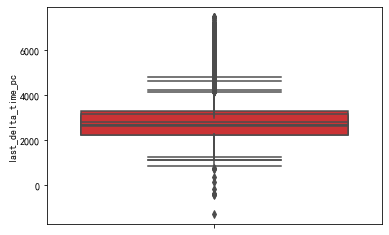

In [55]:
for col in ["delta_time_pc","last_delta_time_pc"]:
    feature_train[col]=deal_outliers(feature_train,col)
    feature_test[col]=deal_outliers(feature_test,col)

# 数据转化和归一化

In [56]:
def pd2onehot(df,col,name_rule):
    temp=pd.get_dummies(df[col])
    df=pd.concat([df,temp],axis=1)
    df.rename(name_rule, axis=1, inplace=True)
    return df

In [57]:
feature_train=pd2onehot(feature_train,"action_type",{"DELIVERY":"now_DELIVERY","PICKUP":"now_PICKUP"})
feature_train=pd2onehot(feature_train,"last_action_type",{"DELIVERY":"last_DELIVERY","PICKUP":"last_PICKUP"})
feature_train=pd2onehot(feature_train,'old_action_1',{"DELIVERY":"old1_DELIVERY","PICKUP":"old1_PICKUP"})
feature_train=pd2onehot(feature_train,'old_action_2',{"DELIVERY":"old2_DELIVERY","PICKUP":"old2_PICKUP"})
feature_train=pd2onehot(feature_train,'weather_grade',{1:"normal",2:"a_bit_bad",3:"bad",4:"vary_bad",5:"extra_bad"})

feature_test=pd2onehot(feature_test,"action_type",{"DELIVERY":"now_DELIVERY","PICKUP":"now_PICKUP"})
feature_test=pd2onehot(feature_test,"last_action_type",{"DELIVERY":"last_DELIVERY","PICKUP":"last_PICKUP"})
feature_test=pd2onehot(feature_test,'old_action_1',{"DELIVERY":"old1_DELIVERY","PICKUP":"old1_PICKUP"})
feature_test=pd2onehot(feature_test,'old_action_2',{"DELIVERY":"old2_DELIVERY","PICKUP":"old2_PICKUP"})
feature_test=pd2onehot(feature_test,'weather_grade',{1:"normal",2:"a_bit_bad",3:"bad",4:"vary_bad",5:"extra_bad"})

In [58]:
for col in ["target_tan","delivery_tan","last_delivery_tan"]:
    feature_train[col]=(feature_train[col]-feature_train[col].mean())/(feature_train[col].std())   # Z
    feature_test[col]=(feature_test[col]-feature_test[col].mean())/(feature_test[col].std())   #Z
for col in ["delta_time_pc","last_delta_time_pc"]: # max-min
    feature_train[col]=(feature_train[col]- feature_train[col].min()) / (feature_train[col].max() - feature_train[col].min())
    feature_test[col]=(feature_test[col]- feature_test[col].min()) / (feature_test[col].max() - feature_test[col].min())

In [59]:
for col in ['grid_distance',"target_MHD","delivery_MHD","last_delivery_MHD"]:
    feature_train[col]=feature_train[col].apply(lambda x: np.log(1+x))
    feature_test[col]=feature_test[col].apply(lambda x: np.log(1+x))

In [60]:
feature_train.head()

,majorid,courier_id,wave_index,date,tracking_id,action_type,last_tracking_id,last_action_type,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load,weather_grade,delivery_tan,delivery_MHD,last_delivery_tan,last_delivery_MHD,assigned_time,promise_deliver_time,estimate_pick_time,delta_time_pc,last_assigned_time,last_promise_deliver_time,last_estimate_pick_time,last_delta_time_pc,last_time,expect_time,label,courier_wave_start_lng,courier_wave_start_lat,now_DELIVERY,now_PICKUP,last_DELIVERY,last_PICKUP,old1_DELIVERY,old1_PICKUP,old2_DELIVERY,old2_PICKUP,normal,a_bit_bad,bad,vary_bad
0,20200201100002543_0,100002543,0,20200201,2100074542836254538,DELIVERY,2100074536706869066,PICKUP,2,PICKUP,None,7.931285,1.733031,2.485662,3,4.59264,10,1,1.873289,2.485662,1.160630,6.744074,1580518968,1580521500,1580519017,0.607822,1580519088,1580521500,1580485567,0.438705,1580519758,1580520355,1,121.635755,39.141497,1,0,0,1,0,1,0,0,1,0,0,0
1,20200201100002543_0,100002543,0,20200201,2100074536706869066,DELIVERY,2100074536706869066,PICKUP,2,PICKUP,None,8.161660,1.052422,6.744074,3,4.59264,10,1,1.163905,6.744074,1.160630,6.744074,1580519088,1580521500,1580485567,0.431011,1580519088,1580521500,1580485567,0.438705,1580519758,1580520770,0,121.635755,39.141497,1,0,0,1,0,1,0,0,1,0,0,0
2,20200201100002543_1,100002543,1,20200201,2100074546090674142,DELIVERY,2100074546118723550,PICKUP,2,PICKUP,None,8.057377,0.072001,7.953425,3,4.59264,10,1,0.142034,7.953425,0.309513,8.035703,1580523709,1580526417,1580524558,0.439273,1580523889,1580526568,1580524589,0.447482,1580524468,1580525047,1,121.631040,39.137702,1,0,0,1,0,1,0,0,1,0,0,0
3,20200201100002543_1,100002543,1,20200201,2100074546118723550,DELIVERY,2100074546118723550,PICKUP,2,PICKUP,None,8.157370,0.235632,8.035703,3,4.59264,10,1,0.312583,8.035703,0.309513,8.035703,1580523889,1580526568,1580524589,0.431011,1580523889,1580526568,1580524589,0.447482,1580524468,1580525705,0,121.631040,39.137702,1,0,0,1,0,1,0,0,1,0,0,0
4,20200201100002543_2,100002543,2,20200201,2100074572925863604,DELIVERY,2100074572925863604,PICKUP,2,PICKUP,None,8.089789,0.805004,7.234692,3,4.59264,10,1,0.906026,7.234692,0.902813,7.234692,1580549269,1580551902,1580550163,0.422749,1580549269,1580551902,1580550163,0.438849,1580550426,1580550955,1,121.642295,39.135482,1,0,0,1,0,1,0,0,1,0,0,0


In [61]:
feature_test.head()

,majorid,courier_id,wave_index,date,tracking_id,action_type,last_tracking_id,last_action_type,load,old_action_1,old_action_2,grid_distance,target_tan,target_MHD,level,speed,max_load,weather_grade,delivery_tan,delivery_MHD,last_delivery_tan,last_delivery_MHD,assigned_time,promise_deliver_time,estimate_pick_time,delta_time_pc,last_assigned_time,last_promise_deliver_time,last_estimate_pick_time,last_delta_time_pc,last_time,expect_time,label,courier_wave_start_lng,courier_wave_start_lat,now_DELIVERY,now_PICKUP,last_DELIVERY,last_PICKUP,old1_DELIVERY,old1_PICKUP,old2_DELIVERY,old2_PICKUP,normal,a_bit_bad,bad,vary_bad
0,20200301100002543_3,100002543,3,20200301,2100076045156320581,DELIVERY,2100076044139038021,PICKUP,3,PICKUP,PICKUP,7.765145,1.642096,5.768373,3,5.536055,10,1,1.658933,5.768373,1.563800,6.129087,1583036629,1583039154,1583037835,0.440905,1583037289,1583040204,1583038706,0.289873,1583038335,0,None,121.634234,39.143629,1,0,0,1,0,1,0,1,1,0,0,0
1,20200301100002543_3,100002543,3,20200301,2100076044413207877,PICKUP,2100076044139038021,PICKUP,3,PICKUP,PICKUP,0.693147,NaN,0.000000,3,5.536055,10,1,1.714542,5.480707,1.563800,6.129087,1583036809,1583039641,1583038022,0.475031,1583037289,1583040204,1583038706,0.289873,1583038335,0,None,121.634234,39.143629,0,1,0,1,0,1,0,1,1,0,0,0
2,20200301100002543_3,100002543,3,20200301,2100076045016368756,DELIVERY,2100076044139038021,PICKUP,3,PICKUP,PICKUP,8.217439,1.820522,4.787734,3,5.536055,10,1,-1.872481,4.381142,1.563800,6.129087,1583037829,1583040530,1583038430,0.488795,1583037289,1583040204,1583038706,0.289873,1583038335,0,None,121.634234,39.143629,1,0,0,1,0,1,0,1,1,0,0,0
3,20200301100002543_3,100002543,3,20200301,2100076044139038021,DELIVERY,2100076044139038021,PICKUP,3,PICKUP,PICKUP,7.805475,1.549883,6.129087,3,5.536055,10,1,1.565636,6.129087,1.563800,6.129087,1583037289,1583040204,1583038706,0.481743,1583037289,1583040204,1583038706,0.289873,1583038335,0,None,121.634234,39.143629,1,0,0,1,0,1,0,1,1,0,0,0
4,20200301100006950_3,100006950,3,20200301,2100076085507393263,DELIVERY,2100076086461237066,PICKUP,2,PICKUP,DELIVERY,7.294377,0.102299,7.348138,2,5.108438,6,1,0.157160,7.399583,0.327814,7.311422,1583060079,1583063178,1583061259,0.509157,1583060499,1583063341,1583061483,0.279538,1583061548,0,None,121.412991,39.032091,1,0,0,1,0,1,1,0,1,0,0,0


In [62]:
feature_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198056 entries, 0 to 198055
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   majorid                    198056 non-null  object 
 1   courier_id                 198056 non-null  int64  
 2   wave_index                 198056 non-null  int64  
 3   date                       198056 non-null  object 
 4   tracking_id                198056 non-null  object 
 5   action_type                198056 non-null  object 
 6   last_tracking_id           198056 non-null  object 
 7   last_action_type           198056 non-null  object 
 8   load                       198056 non-null  int64  
 9   old_action_1               198056 non-null  object 
 10  old_action_2               134942 non-null  object 
 11  grid_distance              198056 non-null  float64
 12  target_tan                 198056 non-null  float64
 13  target_MHD                 19

In [63]:
feature_train.to_pickle('../user_data/tmp_data/feature_train.pkl')
feature_test.to_pickle('../user_data/tmp_data/feature_test.pkl')